## **Graphical Results**

In [ ]:
# Installing required libraries

# !pip install ipython-autotime  --quiet
# !pip install paretoset --quiet
# !pip install genai_evaluation --quiet
# !pip install pymoo --quiet
# %load_ext autotime

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# import gdown

from sklearn.metrics import PredictionErrorDisplay
import matplotlib.patches as mpatches
from itertools import cycle
import matplotlib.colors as mcolors
from timeit import default_timer as timer
import warnings
from collections import defaultdict

import seaborn as sns

from pymoo.indicators.hv import HV
from pymoo.indicators.igd_plus import IGDPlus

from paretoset import paretoset
import random
from genai_evaluation import multivariate_ecdf, ks_statistic
from scipy import stats

In [ ]:
OBJ_STPLUS= ['m1', 'm2', 'p1', 'p2']
OBJ_COCOME = ['m1', 'm2', 'm3', 'm4','p1', 'p2', 'p3', 'p4']

Analysis of reference Pareto fronts (ground truth) versus predicted frontiers with IAL strategy (for different sampling factors). KS tests for the distributions are also included.

In [4]:
# Ground truth values (using only solvers)
SCALED_STPLUS = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/scaled_stplus.csv"
SCALED_COCOME = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/scaled_cocome.csv"

scaled_stplus_df = pd.read_csv(SCALED_STPLUS)
scaled_cocome_df = pd.read_csv(SCALED_COCOME)

In [5]:
# Computing pareto front for ST+ (ground truth)
print(scaled_stplus_df.shape)
mask = paretoset(scaled_stplus_df, sense=["min"]*4)
gt_pf_stplus = scaled_stplus_df[mask]
print("NPS ST+ (gt):", gt_pf_stplus.shape[0])
gt_pf_stplus.head()

(454, 4)
NPS ST+ (gt): 25


,m1,m2,p1,p2
1,0.266631,-2.059924,-0.339601,-0.205074
15,-1.696971,-1.014600,-0.203018,-0.222431
16,0.266631,-1.269398,-0.486492,-0.222636
30,0.266631,-0.478872,-0.612629,-0.200457
39,0.266631,-1.014600,-0.363719,-0.244465


In [6]:
# Computing pareto front for CoCoME (ground truth)
print(scaled_cocome_df.shape)
mask = paretoset(scaled_cocome_df, sense=["min"]*8)
gt_pf_cocome = scaled_cocome_df[mask]
print("NPS CoCoME (gt):", gt_pf_cocome.shape[0])
gt_pf_cocome.head()

(1192, 8)
NPS CoCoME (gt): 32


,m1,m2,m3,m4,p1,p2,p3,p4
0,-0.361104,-0.664689,-0.788151,-0.070163,-0.413973,-0.297389,-0.499175,-0.044066
337,0.025876,0.502472,1.023888,-10.973082,-0.579139,-0.372729,-0.371439,-0.045204
536,-11.390043,0.502472,1.023888,-0.070163,-0.595978,-0.368051,-0.443512,-0.044996
537,0.025876,-8.409689,0.915886,-0.070163,-0.237487,-0.239750,-0.636984,-0.043694
800,0.025876,-8.340123,1.023888,-0.070163,-0.579139,-0.372729,-0.371439,-0.045204


In [7]:
BASELINE_PREDS_STPLUS = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/baseline_preds_naive_stplus.csv"
BASELINE_PREDS_COCOME = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/baseline_preds_naive_cocome.csv"

# Predictions for naive baseline
baseline_preds_stplus_df = pd.read_csv(BASELINE_PREDS_STPLUS)
baseline_preds_cocome_df = pd.read_csv(BASELINE_PREDS_COCOME)

In [8]:
def compute_moo_indicators(reference_pf, pf):

  """Calculates multi-objective optimization (MOO) indicators comparing a Pareto front to a reference.

  This function computes a set of MOO indicators to evaluate the quality of a
  Pareto front (`pf`) relative to a known reference Pareto front (`reference_pf`).
  It provides insights into convergence and diversity of the generated solutions.

  Args:
      reference_pf (np.ndarray): A NumPy array representing the reference Pareto front,
          where each row corresponds to a solution and each column represents
          an objective value.
      pf (np.ndarray): A NumPy array representing the Pareto front to be evaluated,
          with the same structure as `reference_pf`.

  Returns:
      dict: A dictionary containing the computed MOO indicators, where keys
          are the indicator names (e.g., 'GD', 'IGD', 'HV') and values are
          the corresponding indicator values. The specific indicators calculated
          may vary depending on the function's implementation.
  """

  ref_point = reference_pf.max(axis=0).values # Approximate nadir point (worst value)
  # print("Nadir point:", ref_point)
  hv = HV(ref_point=ref_point)
  igd_plus = IGDPlus(reference_pf.values)

  metrics_dict = dict()
  metrics_dict['HV_ref'] = hv(reference_pf.values)
  metrics_dict['HV'] = hv(pf.values)
  metrics_dict['IGD+'] = igd_plus(pf.values)
  metrics_dict['NPS_ref'] = reference_pf.shape[0]
  metrics_dict['NPS'] = pf.shape[0]
  return metrics_dict

def compute_multivariate_ks(validation_data, pred_data, n_nodes=2000, random_seed=2, verbose=False):
  """Calculates the multivariate Kolmogorov-Smirnov (KS) statistic between two datasets.

  This function compares the empirical cumulative distribution functions (ECDFs) of
  `validation_data` and `pred_data` to assess the similarity of their distributions.
  It uses a grid-based approach with `n_nodes` to approximate the ECDFs.

  Args:
      validation_data (np.ndarray): The validation dataset.
      pred_data (np.ndarray): The predicted data.
      n_nodes (int, optional): Number of grid nodes for ECDF approximation. Defaults to 2000.
      random_seed (int, optional): Random seed for reproducibility. Defaults to 2.
      verbose (bool, optional): Whether to print progress information. Defaults to False.

  Returns:
      float: The multivariate KS statistic, representing the maximum separation
             between the ECDFs of the two datasets. A value closer to 0 indicates
             a better fit between the distributions.
  """

  # Calculate ECDFs
  _, ecdf_val, ecdf_pred = multivariate_ecdf(validation_data, pred_data, n_nodes = n_nodes,
                                               verbose = verbose, random_seed=random_seed)
  # Calculates the maximum separation (distance) between the ECDFs and yields a result ranging
  # from 0 (indicating the best fit) and 1 (indicating the worst fit).
  ks_stat = ks_statistic(ecdf_val, ecdf_pred)
  return ks_stat

def compute_univariate_ks(validation_data, pred_data, targets=None):
  """Calculates the univariate Kolmogorov-Smirnov (KS) statistic for each target variable.

  This function compares the distributions of the validation data and the predicted data
  for each target variable using the two-sample KS test. It returns a list of tuples,
  where each tuple contains the KS statistic and p-value for a target variable.

  Args:
      validation_data (np.ndarray): The validation dataset.
      pred_data (np.ndarray): The predicted data.
      targets (list or None, optional): A list of target variable names.
                                        If None, the results will not include target names.
                                        Defaults to None.

  Returns:
      list: A list of tuples, where each tuple contains:
            - If `targets` is provided: (target_name, ks_statistic, p_value)
            - If `targets` is None: (ks_statistic, p_value)
  """

  ks_stats = []
  for x in range(0,validation_data.shape[1]):
    sample1 = validation_data[:,x]
    sample2 = pred_data[:,x]
    ks = stats.ks_2samp(sample1, sample2)
    if targets is None:
      ks_stats.append((ks.statistic,ks.pvalue))
    else:
      ks_stats.append((targets[x],ks.statistic,ks.pvalue))
  return ks_stats


def compute_incremental_moo_indicators(df, baseline_preds, incremental_preds):
  """Calculates and compares Multi-Objective Optimization (MOO) performance indicators for baseline and incremental learning scenarios.

  This function evaluates the performance of a MOO model in two scenarios:
  1. Baseline: Using a baseline model's predictions.
  2. Incremental: Using predictions from a model trained with incrementally added data.

  It computes various MOO indicators (e.g., Hypervolume, IGD+) and statistical tests
  (Kolmogorov-Smirnov) to assess the quality of the predicted Pareto fronts compared
  to the ground truth Pareto front.

  Args:
      df (pd.DataFrame): DataFrame containing the ground truth data with objectives as columns.
      baseline_preds (pd.DataFrame or np.ndarray): Predictions from the baseline model.
      incremental_preds (dict): Dictionary where keys represent the amount of data added
                                (e.g., sampling fraction) and values are DataFrames or arrays
                                of predictions after adding that data.

  Returns:
      pd.DataFrame: A DataFrame containing the computed MOO indicators and statistical
                    test results for both baseline and incremental scenarios, allowing for
                    comparison across different data addition levels.
  """

  mask = paretoset(df, sense=["min"]*len(df.columns))
  gt_pf = df[mask]

  mask = paretoset(baseline_preds, sense=["min"]*len(df.columns))
  pf = baseline_preds[mask]
  moo_indicators = compute_moo_indicators(gt_pf, pf)
  moo_indicators['n_queries'] = 'baseline'
  moo_indicators['kstat-multi'] = compute_multivariate_ks(df, baseline_preds)
  for qa, ks, pvalue in compute_univariate_ks(df.values, baseline_preds.values, targets=df.columns):
    moo_indicators['kstat-'+qa] = ks
    moo_indicators['pvalue-'+qa] = pvalue

  all_dicts = [moo_indicators]
  for nq in incremental_preds.keys():
    df_temp = pd.DataFrame(data=incremental_preds[nq], columns=df.columns)
    mask = paretoset(df_temp, sense=["min"]*len(df.columns))
    pf = baseline_preds[mask]
    moo_indicators = compute_moo_indicators(gt_pf, pf)
    moo_indicators['n_queries'] = nq
    moo_indicators['kstat-multi'] = compute_multivariate_ks(df, df_temp)
    for qa, ks, pvalue in compute_univariate_ks(df.values, df_temp.values, targets=df.columns):
      moo_indicators['kstat-'+qa] = ks
      moo_indicators['pvalue-'+qa] = pvalue
    all_dicts.append(moo_indicators)

  return pd.DataFrame(all_dicts)

In [9]:
# Statistics for ST+
mask = paretoset(baseline_preds_stplus_df, sense=["min"]*4)
pf = baseline_preds_stplus_df[mask]
result = compute_moo_indicators(gt_pf_stplus, pf) # ST+
result['kstat-multi'] = compute_multivariate_ks(scaled_stplus_df, baseline_preds_stplus_df)
result

{'HV_ref': np.float64(51.65768614923578),
 'HV': np.float64(49.779450463067846),
 'IGD+': np.float64(0.08861004090116315),
 'NPS_ref': 25,
 'NPS': 52,
 'kstat-multi': np.float64(0.5506607929515419)}

In [10]:
# KS Statistic and p-value for each objective in ST+
compute_univariate_ks(scaled_stplus_df.values, baseline_preds_stplus_df.values, targets=OBJ_STPLUS)

[('m1', np.float64(0.34801762114537443), np.float64(8.74057248517932e-25)),
 ('m2', np.float64(0.40748898678414097), np.float64(4.253341420666999e-34)),
 ('p1', np.float64(0.14977973568281938), np.float64(7.344555376478549e-05)),
 ('p2', np.float64(0.1828193832599119), np.float64(4.799640886822356e-07))]

In [11]:
# Statistics for CoCoME
mask = paretoset(baseline_preds_cocome_df, sense=["min"]*8)
pf = baseline_preds_cocome_df[mask]
result = compute_moo_indicators(gt_pf_cocome, pf)
result['kstat'] = compute_multivariate_ks(scaled_cocome_df, baseline_preds_cocome_df)
result

{'HV_ref': np.float64(0.005680309736197984),
 'HV': np.float64(1.1852067370231425),
 'IGD+': np.float64(0.45943913189831415),
 'NPS_ref': 32,
 'NPS': 79,
 'kstat': np.float64(0.4748322147651007)}

In [12]:
# KS Statistic and p-value for each objective in CoCoME
compute_univariate_ks(scaled_cocome_df.values, baseline_preds_cocome_df.values, targets=OBJ_COCOME)

[('m1', np.float64(0.3640939597315436), np.float64(1.268343906087778e-70)),
 ('m2', np.float64(0.311241610738255), np.float64(2.148458230837458e-51)),
 ('m3', np.float64(0.23825503355704697), np.float64(4.394356321487511e-30)),
 ('m4', np.float64(0.4790268456375839), np.float64(3.5277581309566914e-124)),
 ('p1', np.float64(0.1266778523489933), np.float64(9.437138715446997e-09)),
 ('p2', np.float64(0.19714765100671142), np.float64(1.1389237165521597e-20)),
 ('p3', np.float64(0.18036912751677853), np.float64(2.3660227613749963e-17)),
 ('p4', np.float64(0.9261744966442953), np.float64(0.0))]

In [ ]:
# preds_by_sf_stplus
# preds_by_sf_cocome

# pd.DataFrame(data=preds_by_sf_stplus[0.1], columns=scaled_stplus_df.columns)
# pd.DataFrame(data=preds_by_sf_cocome[0.1], columns=scaled_cocome_df.columns)

In [14]:
STPLUS_METRICS_INCREMENTAL_ALL = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/stplus-incremental-all.csv"
COCOME_METRICS_INCREMENTAL_ALL = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/cocome-incremental-all.csv"

# df_metrics_stplus_all = df_metrics_stplus[df_metrics_stplus['exp']=='incremental - all']
df_metrics_stplus_all = pd.read_csv(STPLUS_METRICS_INCREMENTAL_ALL)
# df_metrics_cocome_all = df_metrics_cocome[df_metrics_cocome['exp']=='incremental - all']
df_metrics_cocome_all = pd.read_csv(COCOME_METRICS_INCREMENTAL_ALL)

In [ ]:
# Compute MOO indicators for ST+ with respect to the ground truth
# results_stplus = compute_incremental_moo_indicators(scaled_stplus_df, baseline_preds_stplus_df, preds_by_sf_stplus)

In [ ]:
def plot_metric(df, x, y, color='blue', y_label=None, x_offset=0.1,
                baseline=None, baseline_lb=None):
  if y_label is None:
    y_label = y
  plt.plot(df[x], df[y], color=color, marker='o', label=y_label)
  if baseline is not None:
    plt.axhline(y=baseline, color=color, linestyle='--', linewidth=2.5)
    if baseline_lb is not None:
      plt.text(x_offset, baseline+0.02, baseline_lb)
  plt.legend()

In [17]:
BASELINE_STPLUS = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/baseline_stplus.csv"
BASELINE_COCOME = "https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/results/baseline_cocome.csv"

df_baseline_stplus = pd.read_csv(BASELINE_STPLUS)
df_baseline_cocome = pd.read_csv(BASELINE_COCOME)

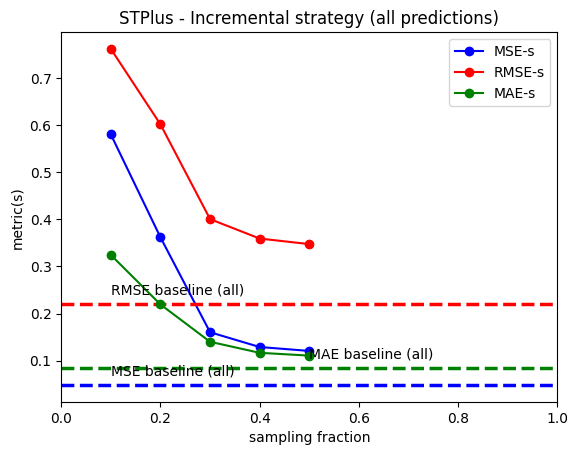

In [18]:
# STPlus
bl = df_baseline_stplus.at[1,'MSE']
plot_metric(df_metrics_stplus_all, 'n_queries', 'MSE', color='blue', y_label='MSE-s',
            baseline=bl, baseline_lb='MSE baseline (all)')
bl = df_baseline_stplus.at[1,'RMSE']
plot_metric(df_metrics_stplus_all, 'n_queries', 'RMSE', color='red', y_label='RMSE-s',
            baseline=bl, baseline_lb='RMSE baseline (all)')
bl = df_baseline_stplus.at[1,'MAE']
plot_metric(df_metrics_stplus_all, 'n_queries', 'MAE', color='green', y_label='MAE-s',
            baseline=bl, baseline_lb='MAE baseline (all)', x_offset=0.5)

plt.xlabel("sampling fraction")
plt.ylabel("metric(s)")
plt.xlim(0,1)
plt.title("STPlus - Incremental strategy (all predictions)")
plt.show()

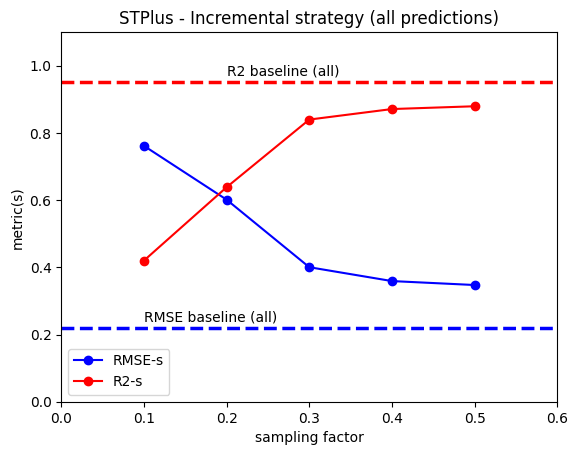

In [19]:
# STPlus
bl = df_baseline_stplus.at[1,'RMSE']
plot_metric(df_metrics_stplus_all, 'n_queries', 'RMSE', color='blue', y_label='RMSE-s',
            baseline=bl, baseline_lb='RMSE baseline (all)')
bl = df_baseline_stplus.at[1,'R2']
plot_metric(df_metrics_stplus_all, 'n_queries', 'R2', color='red', y_label='R2-s',
            baseline=bl, baseline_lb='R2 baseline (all)', x_offset=0.2)

plt.xlabel("sampling factor")
plt.ylabel("metric(s)")
plt.title("STPlus - Incremental strategy (all predictions)")
plt.ylim(0,1.1)
plt.xlim(0,0.6)
plt.savefig("stplus-r2rmse.pdf", format='pdf')
plt.show()

In [20]:
# Compute MOO indicators for CoCoME with respect to the ground truth
# results_cocome = compute_incremental_moo_indicators(scaled_cocome_df, baseline_preds_cocome_df, preds_by_sf_cocome)

In [21]:
df_baseline_cocome

,exp,size,features,R2,MSE,RMSE,MAE,MAPE,time
0,naive - test set,596,919,0.562448,0.437552,0.661477,0.209295,2.049106,9.101941
1,naive - whole set,1192,919,0.655811,0.344189,0.586677,0.159475,48.199236,9.101941


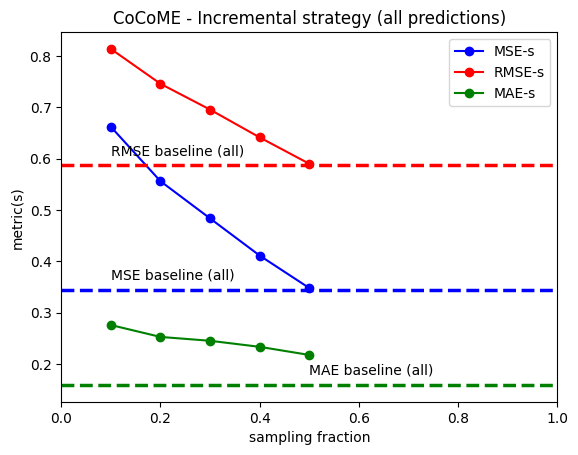

In [22]:
# CoCoME
bl = df_baseline_cocome.at[1,'MSE']
plot_metric(df_metrics_cocome_all, 'n_queries', 'MSE', color='blue', y_label='MSE-s',
            baseline=bl, baseline_lb='MSE baseline (all)')
bl = df_baseline_cocome.at[1,'RMSE']
plot_metric(df_metrics_cocome_all, 'n_queries', 'RMSE', color='red', y_label='RMSE-s',
            baseline=bl, baseline_lb='RMSE baseline (all)')
bl = df_baseline_cocome.at[1,'MAE']
plot_metric(df_metrics_cocome_all, 'n_queries', 'MAE', color='green', y_label='MAE-s',
            baseline=bl, baseline_lb='MAE baseline (all)', x_offset=0.5)

plt.xlabel("sampling fraction")
plt.ylabel("metric(s)")
plt.xlim(0,1)
plt.title("CoCoME - Incremental strategy (all predictions)")
plt.show()

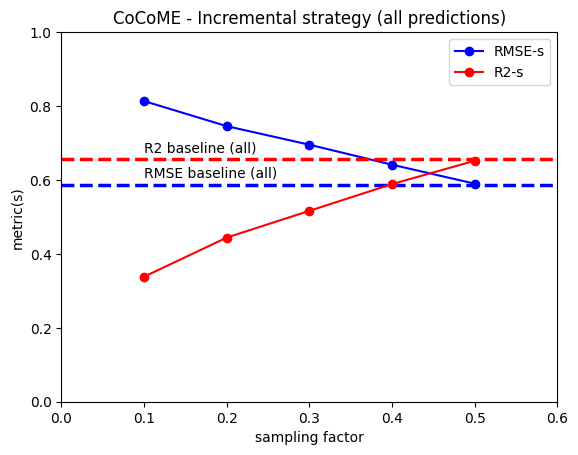

In [23]:
# CoCoME
bl = df_baseline_cocome.at[1,'RMSE']
plot_metric(df_metrics_cocome_all, 'n_queries', 'RMSE', color='blue', y_label='RMSE-s',
            baseline=bl, baseline_lb='RMSE baseline (all)')
bl = df_baseline_cocome.at[1,'R2']
plot_metric(df_metrics_cocome_all, 'n_queries', 'R2', color='red', y_label='R2-s',
            baseline=bl, baseline_lb='R2 baseline (all)')

plt.xlabel("sampling factor")
plt.ylabel("metric(s)")
plt.ylim(0,1)
plt.xlim(0,0.6)
plt.title("CoCoME - Incremental strategy (all predictions)")
plt.savefig("cocome-r2rmse.pdf", format='pdf')
plt.show()

In [24]:
df_metrics_cocome_all['case'] = 'cocome-incremental'
df_metrics_stplus_all['case'] = 'stplus-incremental'
df_metrics_both_all = pd.concat([df_metrics_stplus_all, df_metrics_cocome_all]).reset_index(drop=True)
df_metrics_both_all

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries,case
0,incremental - all,454,734,72,3.738188,0.420027,0.579973,0.761560,0.324268,0.799581,0.1,stplus-incremental
1,incremental - all,454,734,115,4.355682,0.638420,0.361580,0.601315,0.219228,0.624820,0.2,stplus-incremental
2,incremental - all,454,734,157,4.927842,0.839724,0.160276,0.400344,0.140052,0.410203,0.3,stplus-incremental
3,incremental - all,454,734,200,4.537649,0.871057,0.128943,0.359087,0.116617,0.362951,0.4,stplus-incremental
4,incremental - all,454,734,242,4.654522,0.879361,0.120639,0.347331,0.110716,0.336533,0.5,stplus-incremental
5,incremental - all,1192,919,231,66.696487,0.338095,0.661905,0.813575,0.276066,0.935466,0.1,cocome-incremental
6,incremental - all,1192,919,338,70.989174,0.443947,0.556053,0.745690,0.252906,0.594637,0.2,cocome-incremental
7,incremental - all,1192,919,445,72.005198,0.516388,0.483612,0.695422,0.245403,0.636324,0.3,cocome-incremental
8,incremental - all,1192,919,552,77.306337,0.588712,0.411288,0.641317,0.233612,0.588609,0.4,cocome-incremental
9,incremental - all,1192,919,658,78.070003,0.651903,0.348097,0.589997,0.217834,0.539427,0.5,cocome-incremental


In [25]:
# Assumptions
# - transformation of arch. instances in STPLUS = 30 secs (approximately)
# - transformation of arch. instances in COCOME = 1 min (approximately)

def estimate_computation_times(n_instances, sampling_fraction, solver_average_execution, surrogate_execution):
  total_computation_time = n_instances * solver_average_execution
  surrogate_computation_time = n_instances*sampling_fraction*solver_average_execution + surrogate_execution
  return total_computation_time, surrogate_computation_time

def compute_time_for_casestudy(case_study, solver_average_execution, ninstances, df):
  df_metrics = df[df['case']==case_study]
  times = []
  for n in df_metrics['n_queries']:
    #print("-"*50)
    se = df_metrics[df_metrics['n_queries']==n]['time'].tolist()[0]
    print("n_queries:", n, se, ninstances)
    tct, sct = estimate_computation_times(ninstances, n, solver_average_execution, se)
    #print(tct, sct)
    times.append(sct)

  return tct, times


case_study = 'stplus-incremental'
sae = 30 # in secs
print(case_study)
total_time_stplus, times_stplus = compute_time_for_casestudy(case_study, sae, scaled_stplus_df.shape[0], df_metrics_both_all)

print()
case_study = 'cocome-incremental'
sae = 60 # in secs
print(case_study)
total_time_cocome, times_cocome = compute_time_for_casestudy(case_study, sae, scaled_cocome_df.shape[0], df_metrics_both_all)

stplus-incremental
n_queries: 0.1 3.738188401999992 454
n_queries: 0.2 4.355681840000045 454
n_queries: 0.3 4.927841681000018 454
n_queries: 0.4 4.537649095000006 454
n_queries: 0.5 4.654521721000037 454

cocome-incremental
n_queries: 0.1 66.69648732099995 1192
n_queries: 0.2 70.98917424900003 1192
n_queries: 0.3 72.00519757300003 1192
n_queries: 0.4 77.30633732399997 1192
n_queries: 0.5 78.0700029169999 1192


In [26]:
print("Total time (solvers) - ST+=", total_time_stplus)
print("Total time (solvers) - CoCoME=", total_time_cocome)

Total time (solvers) - ST+= 13620
Total time (solvers) - CoCoME= 71520


In [27]:
df_metrics_both_all['computation_time'] = times_stplus + times_cocome
df_metrics_both_all

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries,case,computation_time
0,incremental - all,454,734,72,3.738188,0.420027,0.579973,0.761560,0.324268,0.799581,0.1,stplus-incremental,1365.738188
1,incremental - all,454,734,115,4.355682,0.638420,0.361580,0.601315,0.219228,0.624820,0.2,stplus-incremental,2728.355682
2,incremental - all,454,734,157,4.927842,0.839724,0.160276,0.400344,0.140052,0.410203,0.3,stplus-incremental,4090.927842
3,incremental - all,454,734,200,4.537649,0.871057,0.128943,0.359087,0.116617,0.362951,0.4,stplus-incremental,5452.537649
4,incremental - all,454,734,242,4.654522,0.879361,0.120639,0.347331,0.110716,0.336533,0.5,stplus-incremental,6814.654522
5,incremental - all,1192,919,231,66.696487,0.338095,0.661905,0.813575,0.276066,0.935466,0.1,cocome-incremental,7218.696487
6,incremental - all,1192,919,338,70.989174,0.443947,0.556053,0.745690,0.252906,0.594637,0.2,cocome-incremental,14374.989174
7,incremental - all,1192,919,445,72.005198,0.516388,0.483612,0.695422,0.245403,0.636324,0.3,cocome-incremental,21528.005198
8,incremental - all,1192,919,552,77.306337,0.588712,0.411288,0.641317,0.233612,0.588609,0.4,cocome-incremental,28685.306337
9,incremental - all,1192,919,658,78.070003,0.651903,0.348097,0.589997,0.217834,0.539427,0.5,cocome-incremental,35838.070003


In [28]:
df_baseline_stplus_dict = df_baseline_stplus[df_baseline_stplus['exp']=='naive - whole set'].to_dict('records')[0]
df_baseline_stplus_dict['queries'] = df_baseline_stplus_dict['size']
df_baseline_stplus_dict['n_queries'] = 0.5
df_baseline_stplus_dict['computation_time'] = total_time_stplus
df_baseline_stplus_dict['case'] = 'stplus-solvers'

df_baseline_cocome_dict = df_baseline_cocome[df_baseline_cocome['exp']=='naive - whole set'].to_dict('records')[0]
df_baseline_cocome_dict['queries'] = df_baseline_cocome_dict['size']
df_baseline_cocome_dict['n_queries'] = 0.5
df_baseline_cocome_dict['computation_time'] = total_time_cocome
df_baseline_cocome_dict['case'] = 'cocome-solvers'

# df_metrics_both_all = df_metrics_both_all.append(df_baseline_stplus_dict, ignore_index=True)
# df_metrics_both_all = df_metrics_both_all.append(df_baseline_cocome_dict, ignore_index=True)
df_metrics_both_all = pd.concat([df_metrics_both_all, pd.DataFrame([df_baseline_stplus_dict])], ignore_index=True) # Use concat to append rows. Convert dict to DataFrame first.
df_metrics_both_all = pd.concat([df_metrics_both_all, pd.DataFrame([df_baseline_cocome_dict])], ignore_index=True) # Use concat to append rows. Convert dict to DataFrame first.
df_metrics_both_all

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries,case,computation_time
0,incremental - all,454,734,72,3.738188,0.420027,0.579973,0.761560,0.324268,0.799581,0.1,stplus-incremental,1365.738188
1,incremental - all,454,734,115,4.355682,0.638420,0.361580,0.601315,0.219228,0.624820,0.2,stplus-incremental,2728.355682
2,incremental - all,454,734,157,4.927842,0.839724,0.160276,0.400344,0.140052,0.410203,0.3,stplus-incremental,4090.927842
3,incremental - all,454,734,200,4.537649,0.871057,0.128943,0.359087,0.116617,0.362951,0.4,stplus-incremental,5452.537649
4,incremental - all,454,734,242,4.654522,0.879361,0.120639,0.347331,0.110716,0.336533,0.5,stplus-incremental,6814.654522
5,incremental - all,1192,919,231,66.696487,0.338095,0.661905,0.813575,0.276066,0.935466,0.1,cocome-incremental,7218.696487
6,incremental - all,1192,919,338,70.989174,0.443947,0.556053,0.745690,0.252906,0.594637,0.2,cocome-incremental,14374.989174
7,incremental - all,1192,919,445,72.005198,0.516388,0.483612,0.695422,0.245403,0.636324,0.3,cocome-incremental,21528.005198
8,incremental - all,1192,919,552,77.306337,0.588712,0.411288,0.641317,0.233612,0.588609,0.4,cocome-incremental,28685.306337
9,incremental - all,1192,919,658,78.070003,0.651903,0.348097,0.589997,0.217834,0.539427,0.5,cocome-incremental,35838.070003


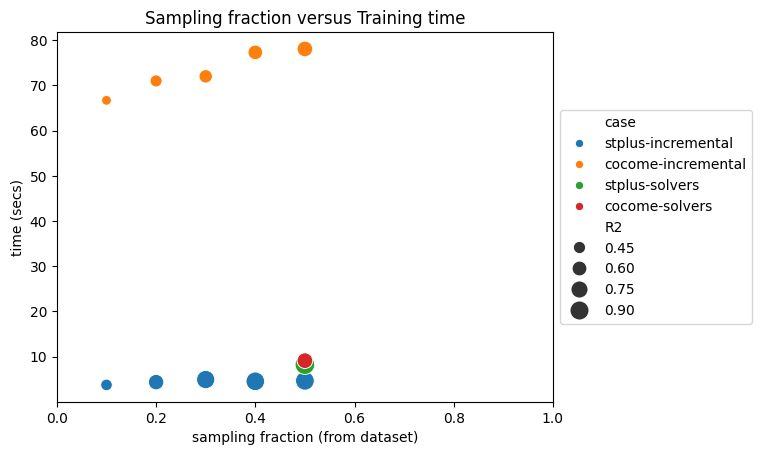

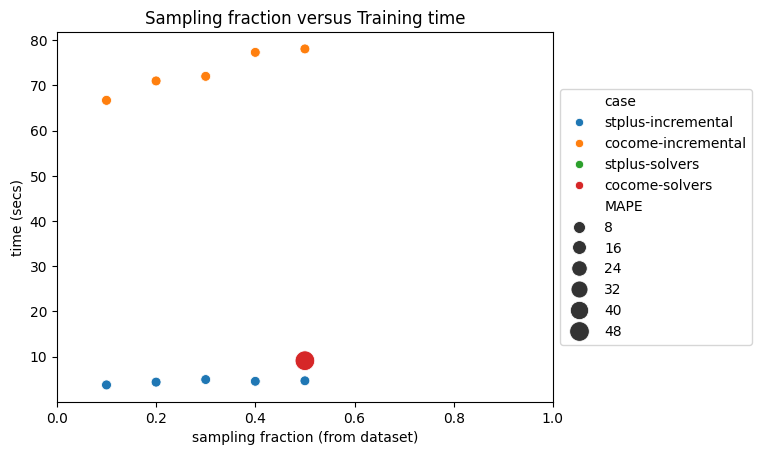

In [29]:
ax = sns.scatterplot(data=df_metrics_both_all, x="n_queries", y="time", size="R2", hue="case", sizes=(50, 200))
ax.set(xlabel='sampling fraction (from dataset)', ylabel='time (secs)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, 1)
plt.title("Sampling fraction versus Training time")
plt.savefig("tradeoff-trainingtime-r2.pdf", format='pdf', bbox_inches = 'tight')
plt.show()

ax = sns.scatterplot(data=df_metrics_both_all, x="n_queries", y="time", size="MAPE", hue="case", sizes=(50, 200))
ax.set(xlabel='sampling fraction (from dataset)', ylabel='time (secs)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, 1)
plt.title("Sampling fraction versus Training time")
plt.savefig("tradeoff-trainingtime-mape.pdf", format='pdf', bbox_inches = 'tight')
plt.show()

In [30]:
df_metrics_both_all.at[10,'n_queries'] = 1.0
df_metrics_both_all.at[11,'n_queries'] = 1.0
df_metrics_both_all.at[10,'case'] = 'stplus-full'
df_metrics_both_all.at[11,'case'] = 'cocome-full'
df_metrics_both_all['computation_time'] = df_metrics_both_all['computation_time'] / 3600
df_metrics_both_all

,exp,size,features,queries,time,R2,MSE,RMSE,MAE,MAPE,n_queries,case,computation_time
0,incremental - all,454,734,72,3.738188,0.420027,0.579973,0.761560,0.324268,0.799581,0.1,stplus-incremental,0.379372
1,incremental - all,454,734,115,4.355682,0.638420,0.361580,0.601315,0.219228,0.624820,0.2,stplus-incremental,0.757877
2,incremental - all,454,734,157,4.927842,0.839724,0.160276,0.400344,0.140052,0.410203,0.3,stplus-incremental,1.136369
3,incremental - all,454,734,200,4.537649,0.871057,0.128943,0.359087,0.116617,0.362951,0.4,stplus-incremental,1.514594
4,incremental - all,454,734,242,4.654522,0.879361,0.120639,0.347331,0.110716,0.336533,0.5,stplus-incremental,1.892960
5,incremental - all,1192,919,231,66.696487,0.338095,0.661905,0.813575,0.276066,0.935466,0.1,cocome-incremental,2.005193
6,incremental - all,1192,919,338,70.989174,0.443947,0.556053,0.745690,0.252906,0.594637,0.2,cocome-incremental,3.993053
7,incremental - all,1192,919,445,72.005198,0.516388,0.483612,0.695422,0.245403,0.636324,0.3,cocome-incremental,5.980001
8,incremental - all,1192,919,552,77.306337,0.588712,0.411288,0.641317,0.233612,0.588609,0.4,cocome-incremental,7.968141
9,incremental - all,1192,919,658,78.070003,0.651903,0.348097,0.589997,0.217834,0.539427,0.5,cocome-incremental,9.955019


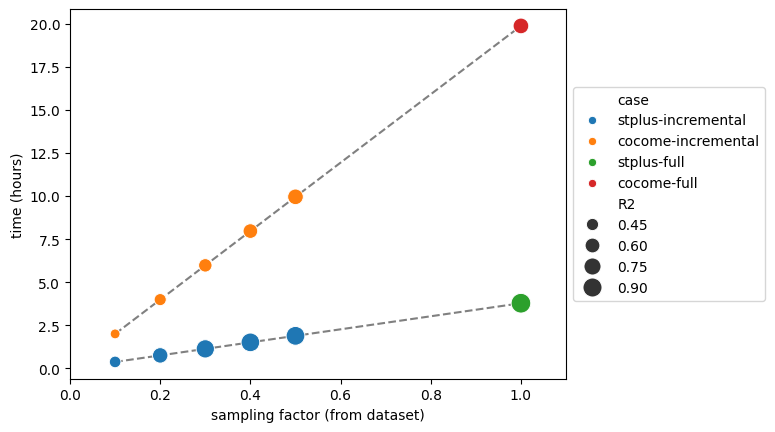

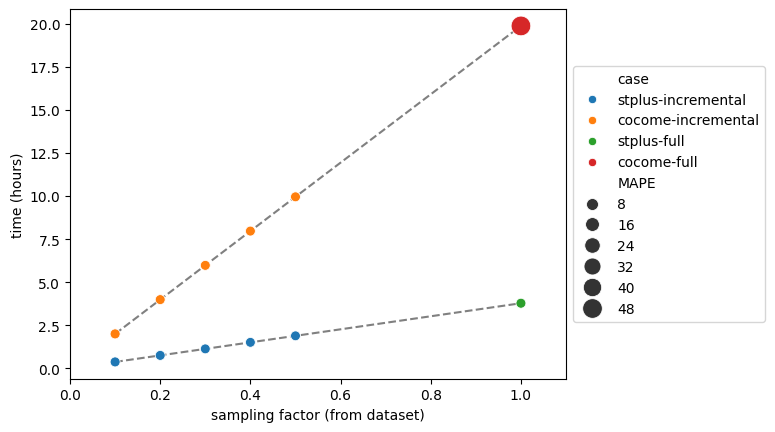

In [31]:
df1 = df_metrics_both_all[(df_metrics_both_all['case']=='stplus-incremental')|(df_metrics_both_all['case']=='stplus-full')]
df2 = df_metrics_both_all[(df_metrics_both_all['case']=='cocome-incremental')|(df_metrics_both_all['case']=='cocome-full')]

plt.plot(df1['n_queries'], df1['computation_time'], color='gray', zorder=0, linestyle = 'dashed')
plt.plot(df2['n_queries'], df2['computation_time'], color='gray', zorder=0, linestyle = 'dashed')
ax = sns.scatterplot(data=df_metrics_both_all, x="n_queries", y="computation_time", size="R2", hue="case", sizes=(50, 200))
ax.set(xlabel='sampling factor (from dataset)', ylabel='time (hours)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_zorder(1)
ax.set_xlim(0, 1.1)
#plt.title("Sampling fraction versus Total computation time")
plt.savefig("tradeoff-computationtime-r2.pdf", format='pdf', bbox_inches = 'tight')
plt.show()

plt.plot(df1['n_queries'], df1['computation_time'], color='gray', zorder=0, linestyle = 'dashed')
plt.plot(df2['n_queries'], df2['computation_time'], color='gray', zorder=0, linestyle = 'dashed')
ax = sns.scatterplot(data=df_metrics_both_all, x="n_queries", y="computation_time", size="MAPE", hue="case", sizes=(50, 200))
ax.set(xlabel='sampling factor (from dataset)', ylabel='time (hours)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, 1.1)
#plt.title("Sampling fraction versus Total computation time")
plt.savefig("tradeoff-computationtime-mape.pdf", format='pdf', bbox_inches = 'tight')
plt.show()


---